# Dirichlet-Multinomial

In [1]:
from matplotlib import pyplot as plt 
import numpy as np  
import pandas as pd
import os, sys
from google.colab import drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd '/content/drive/My Drive/my_datasets/fraud_paper'

#sys.path.append("soccer")

files = os.listdir(os.curdir)
files

[Errno 2] No such file or directory: '/content/drive/My Drive/my_datasets/fraud_paper'
/content


['.config', 'sample_data']

In [14]:
#K = 20    # number of bins
N = 2000
#alphas = [1/2]*K
#p_prior = np.random.dirichlet(alpha = alphas, size = 1)
#p_prior = np.random.dirichlet(alpha = (10,5,3,2,3,7), size = 1)
#p_prior = list(p_prior[0])

In [15]:
#np.random.multinomial(20, p_prior, size=1)

In [16]:
#y = np.random.poisson(5, N)
y = np.random.normal(0,1,N)

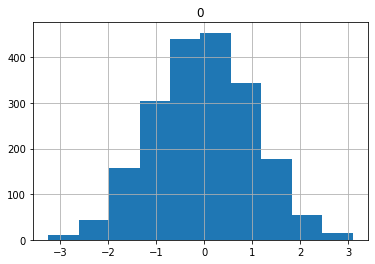

In [ ]:
pd.DataFrame(y).hist();

In [ ]:
#bin_edges, hist = np.unique(y, return_counts=True)

#freq = dict(zip(bin_edges, hist))
#freq

In [ ]:
#N = len(y)
M = 100

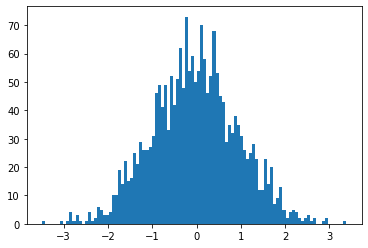

In [ ]:
# create the histogram
counts, bins, patches = plt.hist(y, bins=M, label='hst')

In [ ]:
i = 0
patches[i].get_xy()

(-3.4871612248714245, 0.0)

In [ ]:
patches[i].get_width()

0.06869947680469757

In [ ]:
patches[i].get_height()

1.0

In [ ]:
len(bins)

101

In [ ]:
bins = np.linspace(min(y), max(y), M+1)
counts, bin_edges = np.histogram(y, bins = bins)

In [ ]:
#counts, bin_edges = np.histogram(y, bins = range(M+1))
#dict(zip(bin_edges, counts))

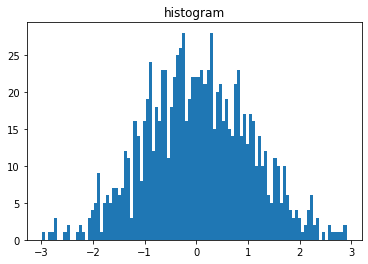

In [ ]:
plt.hist(y, bins=M, label='hst')
plt.title("histogram") 
plt.show()

In [ ]:
len(counts)

100

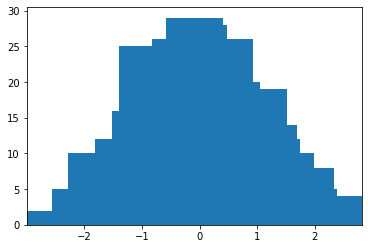

In [ ]:
plt.bar(bin_edges[:-1], counts, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

In [5]:
from scipy.special import loggamma, gamma

def log_post_nbins(M : int, y : np.array):
  """Log posterior of number of bins M
     using conjugate Jeffreys' prior for the bin probabilities 
     and a flat improper prior for the number of bins. This is therefore equivalent to the marginal
     log-likelihood of the number of bins  
  """
  N = len(y)
  counts, bin_edges = np.histogram(y, bins = np.linspace(min(y), max(y), M+1))   # evenly spaced bins
  post_M = N*np.log(M) + loggamma(M/2) -M*loggamma(1/2) -loggamma(N + M/2) + np.sum(loggamma(counts + 1/2)) 
  return post_M
  

In [6]:
from scipy.stats import norm

def rtruncnorm(n, a = -np.inf, b = np.inf, mu = 0, sigma = 1):
    """
    Draw from (double) truncated normal distribution
    Inputs:
    n : size, humber of random draws
    a, b : left, right truncation points
    mu, sigma : mean and standard deviation of normal distr.
    Output:
    Array with draws of length n
    """
    assert b > a, 'Upper truncation point must be strictly greater than lower!'
    u = np.random.uniform(size=n)
    x = norm.ppf((1 - u)*norm.cdf((a - mu)/sigma) + u*norm.cdf((b - mu)/sigma))
    #x = qnorm((1 - u)*self.pnorm((a - mu)/sigma) + u*pnorm((b - mu)/sigma))           # see Lynch for example
    return mu + sigma * x

In [7]:
def geometric_prior(M, gamma = 0.7, max_M = 100):
  """Geometric (power series) prior"""
  #gamma = (gamma < 1)*gamma    # assuming |gamma| < 1 for convergence of the series
  gamma = gamma if 0 < gamma < 1 else 0    # indicator function according to uniform prior 
  P0 = (1-gamma)/(1-gamma**(max_M))
  return P0*(gamma**M) 


In [8]:
def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

In [9]:
def log_joint_post_nbins_gamma(m, gamma, y, max_M):
  return log_post_nbins(m, y) + np.log(geometric_prior(m, gamma, max_M))

In [10]:
def joint_post_nbins_gamma(gamma, y, max_M):
  lpr = {m:log_joint_post_nbins_gamma(m, gamma, y, max_M) for m in range(1,max_M, 1)}
  # Orig scale:
  xx, v = np.array(list(lpr.keys())), np.array(list(lpr.values()))
  return exp_normalize(v)   # posterior values of nbins; circumventing overflow

In [11]:
from scipy.stats import norm, laplace, expon, uniform, multinomial, cauchy

#laplace.pdf(x, loc, scale)

## MCMC cycle:

In [55]:
# Initialize parameters:
current_gam = 0.1
current_m = 2
tune_par = np.sqrt(.02)   # nu; scale
tune_par_M = .5
max_M = 150
MCsim = 2000
samples = np.zeros((MCsim,2))
acc_gamma, acc_M = 0, 0
#------------------------------------------------------------------
for iter in range(MCsim):
  if iter%500 == 0: 
    print(f'Iter: {iter}')
    if iter > 0 : 
      print("Accepted {}".format(round(acc_gamma/iter, 4)))
      #print("Accepted {}".format(round(acc_M/iter, 4)))

  # Start indexing from M=1 
  #cand_M = 1 + np.random.choice(max_M, size=1)[0]
  #cand_M = int(rtruncnorm(n = 1, a = 1, b = max_M, mu = current_M, sigma = tune_par_M)[0])

  # In case of symmetric proposal density (cancels thus can be omitted)
  #num = log_joint_post_nbins_gamma(cand_M, current_gam, y, max_M = max_M) 
  #denom = log_joint_post_nbins_gamma(current_m, current_gam, y, max_M = max_M) 
  #logr = num - denom

  #v = uniform.rvs(size=1)[0]
  #if np.log(v) < logr: 
  #  current_M = cand_M
  #  acc_M += 1

  # Draw directly from the full cond. of M:
  current_M = 1 + np.argmax(np.random.multinomial(n=1, pvals = list(joint_post_nbins_gamma(current_gam, y, max_M)), size=1)[0])
  samples[iter,0] = current_M

  # MH symmetric proposal density:
  #---------------------------------
  #cand_gam = cauchy.rvs(loc = current_gam, scale = tune_par, size=1)[0]
  #cand_gam = expon.rvs(loc = current_gam, scale = tune_par, size=1)[0]
  #cand_gam = laplace.rvs(loc = current_gam, scale = tune_par, size=1)[0]
  #cand_gam = norm.rvs(loc = current_gam, scale = tune_par, size=1)[0]
  cand_gam = rtruncnorm(n = 1, a = 0, b = 1, mu = current_gam, sigma = tune_par)[0]
  #cand_gam = uniform.rvs(size=1)[0]
  #print('Candidate - M {}'.format(current_m))
  #print('Candidate - gamma {}'.format(cand_gam))

  # In case of symmetric proposal density (cancels thus can be omitted)
  num = log_joint_post_nbins_gamma(current_M, cand_gam, y, max_M = max_M) #+ laplace.logpdf(current_gam, loc = cand_gam, scale=.1)
  denom = log_joint_post_nbins_gamma(current_M, current_gam, y, max_M = max_M) #+ laplace.logpdf(cand_gam, loc = current_gam, scale=.1)
  logr = num - denom

  u = uniform.rvs(size=1)[0]
  if np.log(u) < logr: 
    current_gam = cand_gam
    acc_gamma += 1

  samples[iter,1] = current_gam

print('Done!')


Iter: 0
Iter: 500
Accepted 0.624
Iter: 1000
Accepted 0.624
Iter: 1500
Accepted 0.6373
Done!


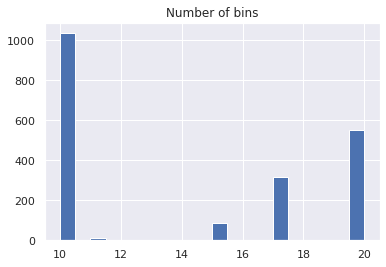

In [56]:
plt.hist(samples[:,0], bins=20, label='hst')
plt.title("Number of bins") 
plt.show()

In [ ]:
# Plot the results:
#------------------------------------
x = np.arange(1,len(samples[:,0])+1); 
fig = plt.figure()
ax = fig.add_subplot(111)
#lines = ax.plot(x, samples[:,0],color="black")
ax.scatter(x, samples[:,0], color="orange")   ;
#ax.set(title = r'Estimation of $y_{t} = f(x_{t-1}) + \epsilon_{t}$ via AR(1)', xlabel = "Time", ylabel="$f(x)$")
#ax.legend(loc = "best")


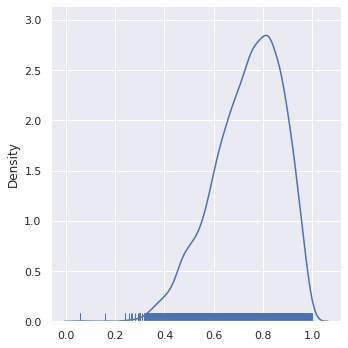

In [43]:
import seaborn as sns #, numpy as np
sns.set_theme()
ax0 = sns.displot(samples[:,1], kind = 'kde',legend=False, rug=True)

0.7568946756201269


0.10926687712339907

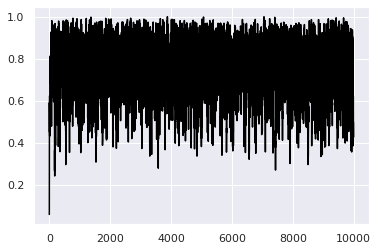

In [44]:
# Plot the results:
#------------------------------------
x = np.arange(1,len(samples[:,1])+1); 
fig = plt.figure()
ax = fig.add_subplot(111)
lines = ax.plot(x, samples[:,1],color="black");
#ax.scatter(x, samples[:,1], color="orange")   

print(np.median(samples[:,1]))
opt_tuning = (2.4**2)*np.var(samples[:,1])
opt_tuning

In [ ]:
# from scipy.stats import expon, gamma, beta
# from scipy import integrate

# lpr2 = {} 
# for m in tqdm(range(1,max_M, 1)):
#   fx = lambda x: log_joint_post_nbins_gamma(m, x, y, max_M)
#   area = integrate.quad(fx, 0, 1)[0]
#   lpr2[m] = area

# fig = plt.figure()
# ax = plt.axes()

# # Log scale:
# #ax.plot(list(lpr2.keys()), list(lpr2.values()));

# # Orig scale:
# xx = np.array(list(lpr2.keys()))
# v = np.array(list(lpr2.values()))
# pr = np.exp(v - v.max())     # posterior values of nbins; circumventing overflow

# #ax.plot(xx, pn)

# s = xx[(xx > 20) & (xx < 70)] 

# ax.plot(s, pr[s])
# #ax.scatter(s, pr[s])
# #ax.bar(s, pr[s])

# ax.set_xlabel('Number of bins')
# ax.set_ylabel('probability')
# ax.set_title('Posterior mass function of K');


In [ ]:
#cand_gam = beta.rvs(a=1, b=3, size = 20000)

#grid_x = np.linspace(0, 1, num=100)
#y_target = log_joint_post_nbins_gamma(cand_m, cand_gam, y, max_M)
#y_proposal = beta.logpdf(cand_gam, a=1, b=3)
#np.mean(y_target/y_proposal)

Generate data:

In [ ]:
N = 10000
y = np.random.normal(0,1,N)

7000


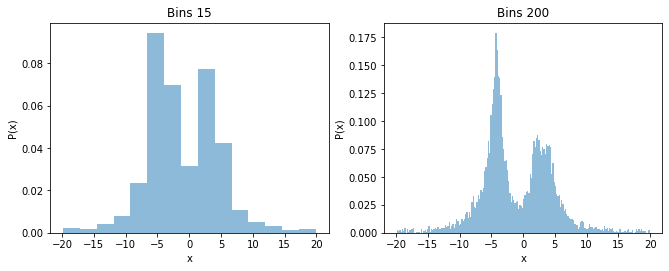

In [ ]:
# https://www.astroml.org/examples/algorithms/plot_bayesian_blocks.html

from scipy import stats
from copy import deepcopy

# draw a set of variables
np.random.seed(42)

t = np.concatenate([stats.cauchy(-5, 1.8).rvs(2000),
                    stats.cauchy(-4, 0.8).rvs(2000),
                    #stats.cauchy(-1, 0.3).rvs(500),
                    stats.cauchy(2, 0.8).rvs(1000),
                    stats.cauchy(4, 1.5).rvs(2000)])
print(len(t))
# truncate values to a reasonable range
t = t[(t > -20) & (t < 20)]

#------------------------------------------------------------
# First figure: show normal histogram binning
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax1 = fig.add_subplot(121)
ax1.hist(t, bins=15, histtype='stepfilled', alpha=0.5, density=True)
ax1.set_xlabel('x')
ax1.set_ylabel('P(x)')
ax1.set_title('Bins 15')

ax2 = fig.add_subplot(122)
ax2.hist(t, bins=200, histtype='stepfilled', alpha=0.5, density=True)
ax2.set_xlabel('x')
ax2.set_ylabel('P(x)')
ax2.set_title('Bins 200')

fig.savefig('cauchy_histogram.png')   # save the figure to file
plt.show()
plt.close(fig)    # close the figure window

y = deepcopy(t)

In [ ]:
from scipy.stats import iqr
from tqdm import tqdm

# Calculate posterior based on flat prior for M:
max_M = 150

#lpr = {} ; #gamma = 0.35
#for m in tqdm(range(1,max_M, 1)):
#  lprob = log_post_nbins(m, y) #+ np.log(geometric_prior(m, gamma = gamma, max_M = max_M))
#  lpr[m] = lprob

lpr = {m:log_post_nbins(m, y) for m in range(1,max_M, 1)}
#lpr = {m:(log_post_nbins(m, y) + np.log(geometric_prior(m, gamma = opt_gamma, max_M = max_M))) for m in range(1,max_M, 1)}

# Orig scale:
xx = np.array(list(lpr.keys()))

v = np.array(list(lpr.values()))
pr = np.exp(v - v.max())     # posterior values of nbins; circumventing overflow

#------------------------------------------------------------
opt_M = max(lpr, key=lpr.get)   # MAP estimate of number of bins

print(f'\nMAP number of bins: {opt_M}')
print(f'Sturges rule: {int(1 + 3.322*np.log(len(y)))}')

# Freedman-Diaconis rule:
bw = 2*iqr(y)*N**(-1/3)
FD = (max(y) - min(y))/bw
print(f'Freedman-Diaconis rule: {int(FD)}')



MAP number of bins: 12
Sturges rule: 26
Freedman-Diaconis rule: 27


Use MAP estimate and calculate histogram estimate of pdf:

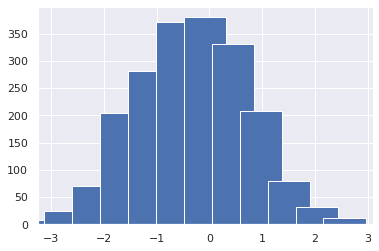

In [ ]:
counts, bin_edges = np.histogram(y, bins = np.linspace(min(y), max(y), opt_M + 1))
plt.bar(bin_edges[:-1], counts)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show();

In [ ]:
#sorted(lpr.items(), key=lambda pair: pair[1], reverse=True)
#sorted(lpr.keys(), reverse=True)

Plot log-posterior of number of bins:

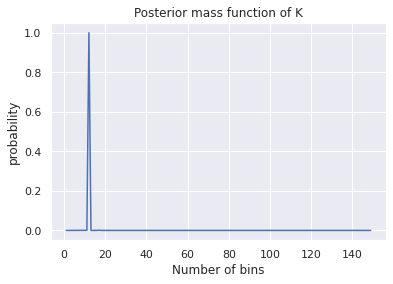

In [ ]:
#dict(zip(range(1,max_M, 1), lpr))

fig = plt.figure()
ax = plt.axes()

# Log scale:
#ax.plot(list(lpr.keys()), list(lpr.values()));

# Orig scale:
xx = np.array(list(lpr.keys()))
v = np.array(list(lpr.values()))
pr = np.exp(v - v.max())     # posterior values of nbins; circumventing overflow
#np.argmax(pr) + 1
#ax.plot(xx, pn)

s = xx[(xx > 20) & (xx < 70)] 
ax.plot(xx, pr)
#ax.plot(s, pr[s])
#ax.scatter(s, pr[s])
#ax.bar(s, pr[s])

ax.set_xlabel('Number of bins')
ax.set_ylabel('probability')
ax.set_title('Posterior mass function of K')

fig.savefig('post_k.png')   # save the figure to file
plt.show()
plt.close(fig)    # close the figure window


Plot prior of number of bins:

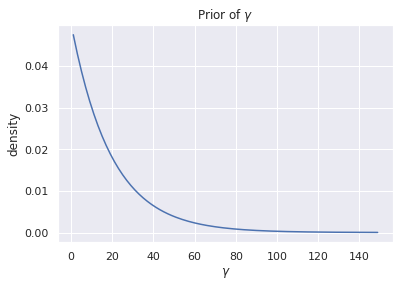

In [ ]:
#max_M = 200
gamma = 0.95
gp = [geometric_prior(m, gamma = gamma, max_M = max_M) for m in range(1,max_M, 1)] 

fig = plt.figure()
ax = plt.axes()
ax.plot(range(1,max_M, 1), gp)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('density')
ax.set_title(r'Prior of $\gamma$');


In [ ]:
def log_post_gamma(gamma : float, lpr : dict, eps = 1e-10):
  """
  Reuse pre-calculated log-posterior prob. masses of M ('lpr') (implying a flat prior) 
  and combining it with the log-geometric prior on M
  """
  lpr2 = {}; max_M = max(list(lpr.keys()))
  for m, lprob_m in lpr.items():
    lpr2[m] = lprob_m + np.log(geometric_prior(m, gamma = gamma, max_M = max_M) + eps)   #joint log posterior
  v = list(lpr2.values())      # log posterior values of M; sum over support of posterior of M next
  log_gamma = np.log(np.sum(np.exp(v - max(v))))   # Marginalize/Sum over all number of bins : logSumExp trick
  return log_gamma


Log-posterior of gamma:

0.15962025316455697


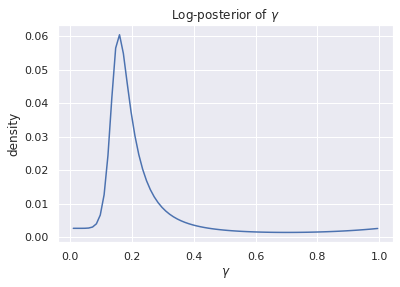

In [ ]:
# Evaluate on grid of gamma values
lp_gam = {g:log_post_gamma(gamma = g, lpr = lpr) for g in np.linspace(0.01,0.995, 80)}

opt_gamma = max(lp_gam, key=lp_gam.get)   # MAP estimate of gamma
print(opt_gamma)

fig = plt.figure()
ax = plt.axes()
ax.plot(list(lp_gam.keys()), list(lp_gam.values()))

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('density')
ax.set_title(r'Log-posterior of $\gamma$')

fig.savefig('post_gam.png')   # save the figure to file
plt.show()
plt.close(fig)    # close the figure window


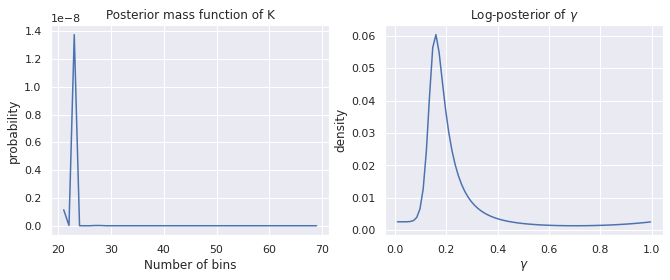

In [ ]:
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax1 = fig.add_subplot(121)
ax1.plot(s, pr[s])
#ax.scatter(s, pr[s])
#ax.bar(s, pr[s])

ax1.set_xlabel('Number of bins')
ax1.set_ylabel('probability')
ax1.set_title('Posterior mass function of K')

ax2 = fig.add_subplot(122)
ax2.plot(list(lp_gam.keys()), list(lp_gam.values()))
ax2.set_xlabel(r'$\gamma$')
ax2.set_ylabel('density')
ax2.set_title(r'Log-posterior of $\gamma$')

fig.savefig('posteriors.png')   # save the figure to file
plt.show()
plt.close(fig)    # close the figure window


### END

No handles with labels found to put in legend.


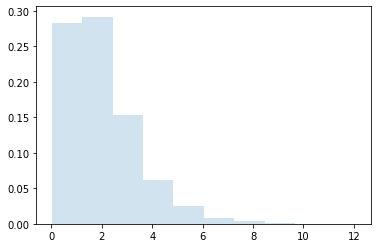

In [ ]:
#r = np.random.exponential(scale=5, size=N)
from scipy.stats import expon, gamma

#r = expon.rvs(loc = 10, size=N)
r = gamma.rvs(loc = 0, a = 2, size=N)

fig, ax = plt.subplots(1, 1)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show();